In [2]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings
from importlib import reload
import random
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas
import PIL.Image as Image
# disable PIL.DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None

from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm
warnings.simplefilter('ignore', UndefinedMetricWarning)

try:
    from vit_pytorch.vit_3d import ViT
except:
    print("Need to install vit_pytorch...")
    !pip install vit-pytorch
    from vit_pytorch.vit_3d import ViT

import utils

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


Loading fragment from data/train/1:   0%|          | 0/24 [00:00<?, ?it/s]

Loading fragment from data/train/2:   0%|          | 0/24 [00:00<?, ?it/s]

Loading fragment from data/train/3:   0%|          | 0/24 [00:00<?, ?it/s]

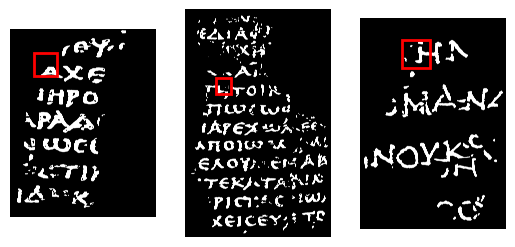

In [3]:
from utils import get_rect_dset, show_labels_with_rects

rects = [(1050, 1050, 1000, 1000), (2000, 4500, 1000, 1000), (1500, 800, 1000, 1000)]
Z_START = 8
Z_DIM = 24
BUFFER = 45
BATCH_SIZE = 32

dsets = [get_rect_dset(f"data/train/{i+1}", z_start=Z_START, z_dim=Z_DIM,
                       buffer=BUFFER, rect=rects[i])
         for i in range(3)]
all_dset = data.ConcatDataset(dsets)
train_dset, val_dset = train_test_split(all_dset, test_size=0.2, random_state=4, shuffle=True)

show_labels_with_rects([1, 2, 3], "data", rects)

In [4]:
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=True)
print(f"{len(train_loader)} training batches, {len(val_loader)} validation batches of batch size {BATCH_SIZE}")

75151 training batches, 18788 validation batches of batch size 32


In [5]:
model = ViT(image_size = 91,           # image size
            frames = 24,               # number of frames
            image_patch_size = 13,     # image patch size
            frame_patch_size = 4,      # frame patch size
            
            num_classes = 1,           # dirty hack that should be replaced
                                       # the model will output a single logit,
                                       # which can be used for binary classification
            channels = 1,
            dim = 1024,
            depth = 6,
            heads = 8,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1)

In [6]:
# test model
subvolumes, labels = next(iter(train_loader))
outputs = model(subvolumes)
print(subvolumes.shape)
print(outputs)
print(outputs.shape)

torch.Size([32, 1, 24, 91, 91])
tensor([[-0.1506],
        [ 0.2282],
        [-0.1116],
        [ 0.4142],
        [-0.5172],
        [ 0.3096],
        [-0.0081],
        [ 0.0949],
        [-0.2359],
        [-0.6793],
        [-0.6764],
        [-0.1537],
        [ 0.1076],
        [-0.4306],
        [ 0.0301],
        [ 0.1425],
        [-0.3048],
        [-0.1957],
        [-0.0950],
        [-0.0060],
        [-0.0742],
        [-0.5500],
        [-0.3786],
        [ 0.1733],
        [ 0.0671],
        [-0.0871],
        [-0.2229],
        [-0.0436],
        [-0.1907],
        [-0.4778],
        [-0.2879],
        [-0.5209]], grad_fn=<AddmmBackward0>)
torch.Size([32, 1])


In [7]:
criterion = nn.BCEWithLogitsLoss()
print(outputs.shape)
print(labels.shape)
print(labels.dtype)
loss = criterion(outputs, labels)
print(loss)
loss.backward()

torch.Size([32, 1])
torch.Size([32, 1])
torch.float32
tensor(0.6470, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [29]:
# Comparison of this model and the InkDetector
from torchinfo import summary
summary(model, input_data=subvolumes, col_width=20, row_settings=["var_names"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        depth=5)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 1, 24, 91, 91]  [32, 1]              303,104              True
├─Sequential (to_patch_embedding)                  [32, 1, 24, 91, 91]  [32, 294, 1024]      --                   True
│    └─Rearrange (0)                               [32, 1, 24, 91, 91]  [32, 294, 676]       --                   --
│    └─LayerNorm (1)                               [32, 294, 676]       [32, 294, 676]       1,352                True
│    └─Linear (2)                                  [32, 294, 676]       [32, 294, 1024]      693,248              True
│    └─LayerNorm (3)                               [32, 294, 1024]      [32, 294, 1024]      2,048                True
├─Dropout (dropout)                                [32, 295, 1024]      [32, 295, 1024]      --                   --
├─Transformer (transformer)                    

In [22]:
from utils.models import InkDetector
other_model = InkDetector()
summary(other_model, input_data=subvolumes, col_width=20, row_settings=["var_names"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        depth=3)
# Note that the ViT has approximately 500 times as many parameters, and takes up
# 10x as much space as the InkDetector!

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
InkDetector (InkDetector)                [32, 1, 24, 91, 91]  [32, 1]              --                   True
├─Sequential (encoder)                   [32, 1, 24, 91, 91]  [32, 64]             --                   True
│    └─Conv3d (0)                        [32, 1, 24, 91, 91]  [32, 16, 12, 46, 46] 448                  True
│    └─ReLU (1)                          [32, 16, 12, 46, 46] [32, 16, 12, 46, 46] --                   --
│    └─BatchNorm3d (2)                   [32, 16, 12, 46, 46] [32, 16, 12, 46, 46] 32                   True
│    └─Conv3d (3)                        [32, 16, 12, 46, 46] [32, 32, 6, 23, 23]  13,856               True
│    └─ReLU (4)                          [32, 32, 6, 23, 23]  [32, 32, 6, 23, 23]  --                   --
│    └─BatchNorm3d (5)                   [32, 32, 6, 23, 23]  [32, 32, 6, 23, 23]  64                   True
│    └─Conv3d (6) 

In [31]:
import utils
reload(utils)
import utils.training
reload(utils.training)
from utils.training import Trainer
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
test_trainer = Trainer(model, train_loader, val_loader, optimizer=optimizer,
                       criterion=criterion, scheduler=scheduler, lr=0.02,
                       scheduler_total_steps=30000, scheduler_max_lr=0.02)
test_trainer.time_train_step()
test_trainer.time_val_step()

Trained on 500 batches in 111.09s.
Predicted on 500 validation batches in 47.89s.


500

In [30]:
import utils
reload(utils)
import utils.training
reload(utils.training)
from utils.training import Trainer
model.to("cpu")
other_model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
test_trainer = Trainer(other_model, train_loader, val_loader, optimizer=optimizer,
                       criterion=criterion, scheduler=scheduler, lr=0.02,
                       scheduler_total_steps=30000, scheduler_max_lr=0.02)
test_trainer.time_train_step()
test_trainer.time_val_step()

Trained on 500 batches in 38.07s.
Predicted on 500 validation batches in 10.74s.


500

In [38]:
import utils.training
reload(utils.training)
from utils.training import Trainer
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
test_trainer = Trainer(model, train_loader, val_loader, optimizer=optimizer,
                       criterion=criterion, scheduler=scheduler, lr=0.02,
                       scheduler_total_steps=30000, scheduler_max_lr=0.02,
                       writer="auto", model_name="ViT_save_test")

Created SummaryWriter saving to logs/2023-06-07/ViT_save_test.


In [39]:
test_trainer.train_eval_loop(500, 500, val_period=500, save_period=500)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved a checkpoint at trained_models/ViT_save_test_500_epochs.pt.


In [40]:
del other_model

In [ ]:
model.to(DEVICE)
TRAINING_EPOCHS = 100000 
VALIDATION_EPOCHS = 500
MODEL_NAME = "ViT_75k_items_100k_epochs"
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
trainer = Trainer(model, train_loader, val_loader,
                  optimizer=optimizer,
                  criterion=criterion,
                  lr=0.02,
                  scheduler=scheduler,
                  scheduler_total_steps=TRAINING_EPOCHS,
                  scheduler_max_lr=0.02,
                  scheduler_pct_start=0.1, # faster ramp-up because of longer training
                  model_name=MODEL_NAME,
                  writer="auto",
                  save_period=5000)

trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)

# InkDetector on same dataset
del model
model = InkDetector().to(DEVICE)
TRAINING_EPOCHS = 100000 
VALIDATION_EPOCHS = 500
MODEL_NAME = "InkDetector_75k_items_100k_epochs"
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
trainer = Trainer(model, train_loader, val_loader,
                  optimizer=optimizer,
                  criterion=criterion,
                  lr=0.02,
                  scheduler=scheduler,
                  scheduler_total_steps=TRAINING_EPOCHS,
                  scheduler_max_lr=0.02,
                  scheduler_pct_start=0.1, # faster ramp-up because of longer training
                  model_name=MODEL_NAME,
                  writer="auto",
                  save_period=5000)

trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)


Created SummaryWriter saving to logs/2023-06-07/ViT_75k_items_100k_epochs.


Training:   0%|          | 0/200000 [00:00<?, ?it/s]